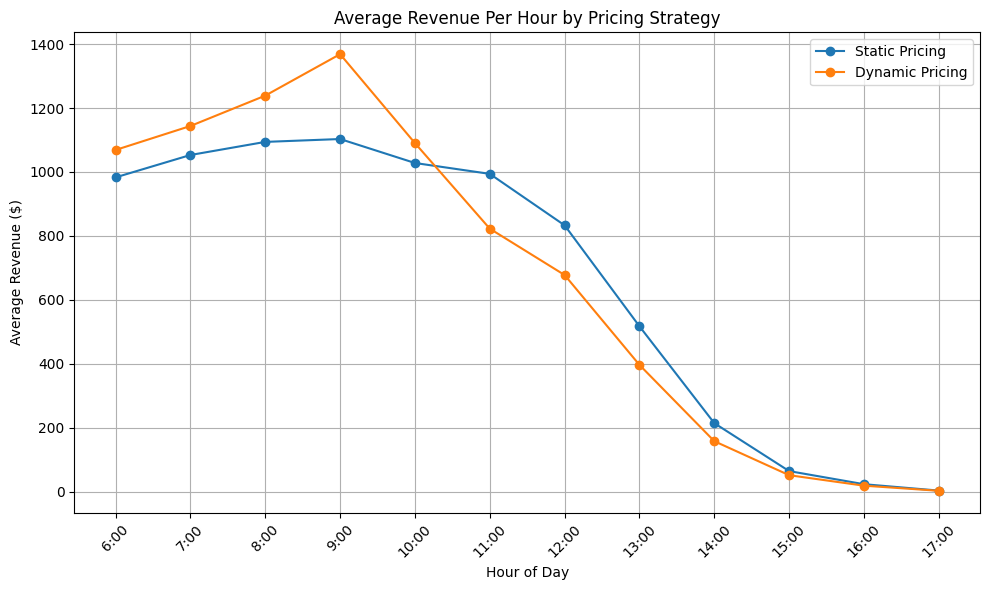

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

NUM_SIMULATIONS = 100
DAY_START = 6 * 60     # 6:00 AM in minutes
DAY_END = 18 * 60      # 6:00 PM in minutes
TEE_INTERVAL = 10      # Tee time interval in minutes
NUM_TEE_TIMES = (DAY_END - DAY_START) // TEE_INTERVAL
MAX_GROUP_SIZE = 4

MEAN_CUSTOMERS = 120
PRICE_SENSITIVITY = 0.05

def satisfaction(price, wait):
    return max(0, 100 - price * 0.4 - wait * 0.6)

def generate_customers():
    customers = []
    count = np.random.poisson(MEAN_CUSTOMERS)

    while len(customers) < count:
        time_pref = np.random.normal(loc=9.5 * 60, scale=2.5 * 60)
        if DAY_START <= time_pref < DAY_END:
            time_pref = int(time_pref)
            group_size = np.random.randint(1, MAX_GROUP_SIZE + 1)
            sensitivity = np.random.uniform(0.5, 1.5)
            customers.append({
                'arrival_time': time_pref,
                'group_size': group_size,
                'sensitivity': sensitivity
            })
    return customers

def create_tee_times():
    tee_times = []
    for t in range(DAY_START, DAY_END, TEE_INTERVAL):
        tee_times.append({
            'time': t,
            'available': MAX_GROUP_SIZE,
            'bookings': []
        })
    return tee_times

def simulate(customers, tee_times, strategy='static'):
    revenue = 0
    utilization = 0
    satisfaction_scores = []
    revenue_by_hour = [0] * 12  # 12 hours from 6 AM to 6 PM

    def get_price(minute_of_day):
        hour = minute_of_day // 60
        if strategy == 'static':
            return 100
        else:
            if 6 <= hour < 9:
                return 125
            elif 9 <= hour < 12:
                return 175
            elif 12 <= hour < 14:
                return 125
            else:
                return 80

    for customer in customers:
        arrival = customer['arrival_time']
        sensitivity = customer['sensitivity']
        group_size = customer['group_size']

        preferred_slot = (arrival - DAY_START) // TEE_INTERVAL
        best_slot = None
        min_wait = float('inf')

        for offset in range(-3, 4):
            slot = preferred_slot + offset
            if 0 <= slot < NUM_TEE_TIMES:
                if tee_times[slot]['available'] >= group_size:
                    best_slot = slot
                    min_wait = abs(offset) * TEE_INTERVAL
                    break

        if best_slot is not None:
            tee_minute = DAY_START + best_slot * TEE_INTERVAL
            hour_index = (tee_minute - DAY_START) // 60
            price = get_price(tee_minute)
            if price * sensitivity <= 150:
                tee_times[best_slot]['available'] -= group_size
                tee_times[best_slot]['bookings'].append(customer)
                revenue += price
                revenue_by_hour[hour_index] += price
                utilization += group_size
                satisfaction_scores.append(satisfaction(price, min_wait))

    return {
        'revenue': revenue,
        'revenue_by_hour': revenue_by_hour,
        'utilization': utilization,
        'avg_satisfaction': np.mean(satisfaction_scores) if satisfaction_scores else 0
    }

def run_simulations(num_trials=100):
    static_hourly = np.zeros(12)
    dynamic_hourly = np.zeros(12)

    for _ in range(num_trials):
        customers = generate_customers()

        static = simulate(customers, create_tee_times(), strategy='static')
        dynamic = simulate(customers, create_tee_times(), strategy='dynamic')

        static_hourly += static['revenue_by_hour']
        dynamic_hourly += dynamic['revenue_by_hour']

    avg_static_hourly = static_hourly / num_trials
    avg_dynamic_hourly = dynamic_hourly / num_trials

    return avg_static_hourly, avg_dynamic_hourly

def plot_hourly_revenue(avg_static_hourly, avg_dynamic_hourly):
    hours = [f"{6 + i}:00" for i in range(12)]

    plt.figure(figsize=(10, 6))
    plt.plot(hours, avg_static_hourly, label='Static Pricing', marker='o')
    plt.plot(hours, avg_dynamic_hourly, label='Dynamic Pricing', marker='o')
    plt.title("Average Revenue Per Hour by Pricing Strategy")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Revenue ($)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    avg_static_hourly, avg_dynamic_hourly = run_simulations()
    plot_hourly_revenue(avg_static_hourly, avg_dynamic_hourly)


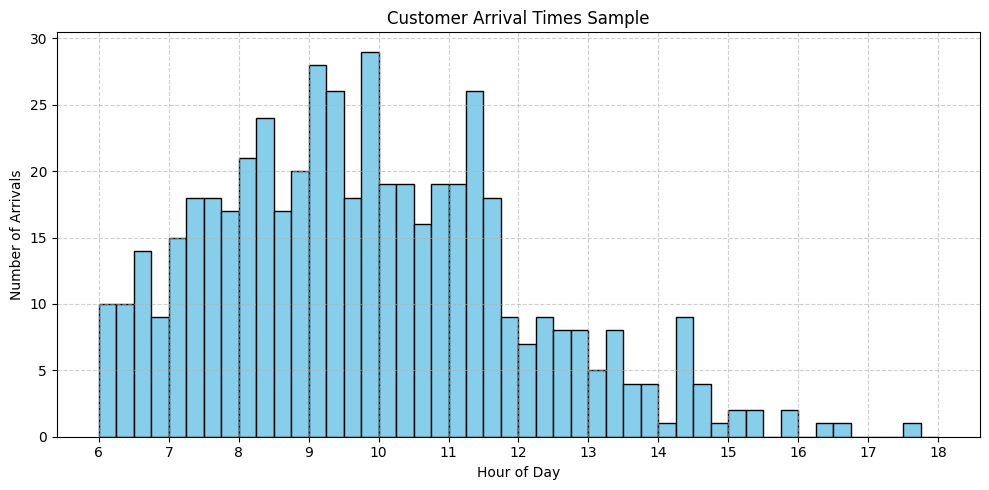

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
DAY_START = 6 * 60     # 6:00 AM in minutes
DAY_END = 18 * 60      # 6:00 PM in minutes
MEAN_CUSTOMERS = 120

def generate_arrival_times(num_customers=MEAN_CUSTOMERS):
    arrival_times = []
    count = np.random.poisson(num_customers)

    while len(arrival_times) < count:
        time_pref = np.random.normal(loc=9.5 * 60, scale=2.5 * 60)
        if DAY_START <= time_pref < DAY_END:
            arrival_times.append(int(time_pref))

    return arrival_times


arrival_times = generate_arrival_times(500)

arrival_hours = np.array(arrival_times) / 60

plt.figure(figsize=(10, 5))
plt.hist(arrival_hours, bins=np.arange(6, 18.1, 0.25), edgecolor='black', color='skyblue')
plt.title("Customer Arrival Times Sample")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Arrivals")
plt.xticks(np.arange(6, 19, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
